In [ ]:
# SARS-CoV-2 infection dynamics: clustering + cell-type identification + pseudotime
# Reproduce neighbourhood clustering and cell type ID for GSE166766
# Reference: Ravindra et al., PLOS Biology (GSE166766). See links/DOI in the notebook header.


In [1]:
pip install --upgrade scanpy anndata scvelo leidenalg matplotlib seaborn umap-learn scikit-misc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.8/196.8 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 103.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.0 MB/s eta 0:00:00
  Created whe

In [6]:
# Imports
import os
import scanpy as sc
import scvelo as scv
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, figsize=(6,6))

In [3]:
def load_dataset(path, condition):
    adata = sc.read_10x_mtx(path, var_names='gene_symbols')
    adata.obs['condition'] = condition

    # QC gene flags
    adata.var['MT']   = adata.var_names.str.startswith("MT-")
    adata.var['RIBO'] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var['HB']   = adata.var_names.str.match(r"^HB[^P]")

    return adata

In [5]:
import scanpy as sc

# Download and extract the GSE166766 raw data
# Remove existing corrupted tar files if they exist
!rm -f GSE166766_RAW.tar GSE166766_RAW.tar.1
# Force re-download
!wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166766/suppl/GSE166766_RAW.tar
!tar -xvf GSE166766_RAW.tar

# Create directories and move/rename files
!mkdir -p mock 1dpi 2dpi 3dpi
!mv GSM5082289_mock_barcodes.tsv.gz mock/barcodes.tsv.gz
!mv GSM5082289_mock_features.tsv.gz mock/features.tsv.gz
!mv GSM5082289_mock_matrix.mtx.gz mock/matrix.mtx.gz

!mv GSM5082290_1dpi_barcodes.tsv.gz 1dpi/barcodes.tsv.gz
!mv GSM5082290_1dpi_features.tsv.gz 1dpi/features.tsv.gz
!mv GSM5082290_1dpi_matrix.mtx.gz 1dpi/matrix.mtx.gz

!mv GSM5082291_2dpi_barcodes.tsv.gz 2dpi/barcodes.tsv.gz
!mv GSM5082291_2dpi_features.tsv.gz 2dpi/features.tsv.gz
!mv GSM5082291_2dpi_matrix.mtx.gz 2dpi/matrix.mtx.gz

!mv GSM5082292_3dpi_barcodes.tsv.gz 3dpi/barcodes.tsv.gz
!mv GSM5082292_3dpi_features.tsv.gz 3dpi/features.tsv.gz
!mv GSM5082292_3dpi_matrix.mtx.gz 3dpi/matrix.mtx.gz

mock      = load_dataset("mock/",  "mock")
dpi1      = load_dataset("1dpi/",  "1dpi")
dpi2      = load_dataset("2dpi/",  "2dpi")
dpi3      = load_dataset("3dpi/",  "3dpi")

mock, dpi1, dpi2, dpi3

--2025-12-03 17:15:15--  ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166766/suppl/GSE166766_RAW.tar
           => ‘GSE166766_RAW.tar’
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.11, 130.14.250.12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /geo/series/GSE166nnn/GSE166766/suppl ... done.
==> SIZE GSE166766_RAW.tar ... 838123520
==> PASV ... done.    ==> RETR GSE166766_RAW.tar ... done.
Length: 838123520 (799M) (unauthoritative)

GSE166766_RAW.tar   100%[===================>] 799.30M  89.7MB/s    in 11s     

2025-12-03 17:15:26 (74.8 MB/s) - ‘GSE166766_RAW.tar’ saved [838123520]

GSM5082289_mock_barcodes.tsv.gz
GSM5082289_mock_features.tsv.gz
GSM5082289_mock_matrix.mtx.gz
GSM5082290_1dpi_barcodes.tsv.gz
GSM5082290_1dpi_features.tsv.gz
GSM5082290_1dpi_matrix.mtx.gz
GSM5082291_2dpi_ba

(AnnData object with n_obs × n_vars = 22609 × 33539
     obs: 'condition'
     var: 'gene_ids', 'feature_types', 'MT', 'RIBO', 'HB',
 AnnData object with n_obs × n_vars = 11834 × 33539
     obs: 'condition'
     var: 'gene_ids', 'feature_types', 'MT', 'RIBO', 'HB',
 AnnData object with n_obs × n_vars = 14695 × 33539
     obs: 'condition'
     var: 'gene_ids', 'feature_types', 'MT', 'RIBO', 'HB',
 AnnData object with n_obs × n_vars = 28530 × 33539
     obs: 'condition'
     var: 'gene_ids', 'feature_types', 'MT', 'RIBO', 'HB')

In [7]:
# 3) QC metrics — compute stats used to filter low-quality cells

for ds in [mock, dpi1, dpi2, dpi3]:
    sc.pp.calculate_qc_metrics(
        ds,
        qc_vars=["MT", "RIBO", "HB"],  # columns defined earlier
        inplace=True,
        log1p=True
    )


QC violin plots for: mock


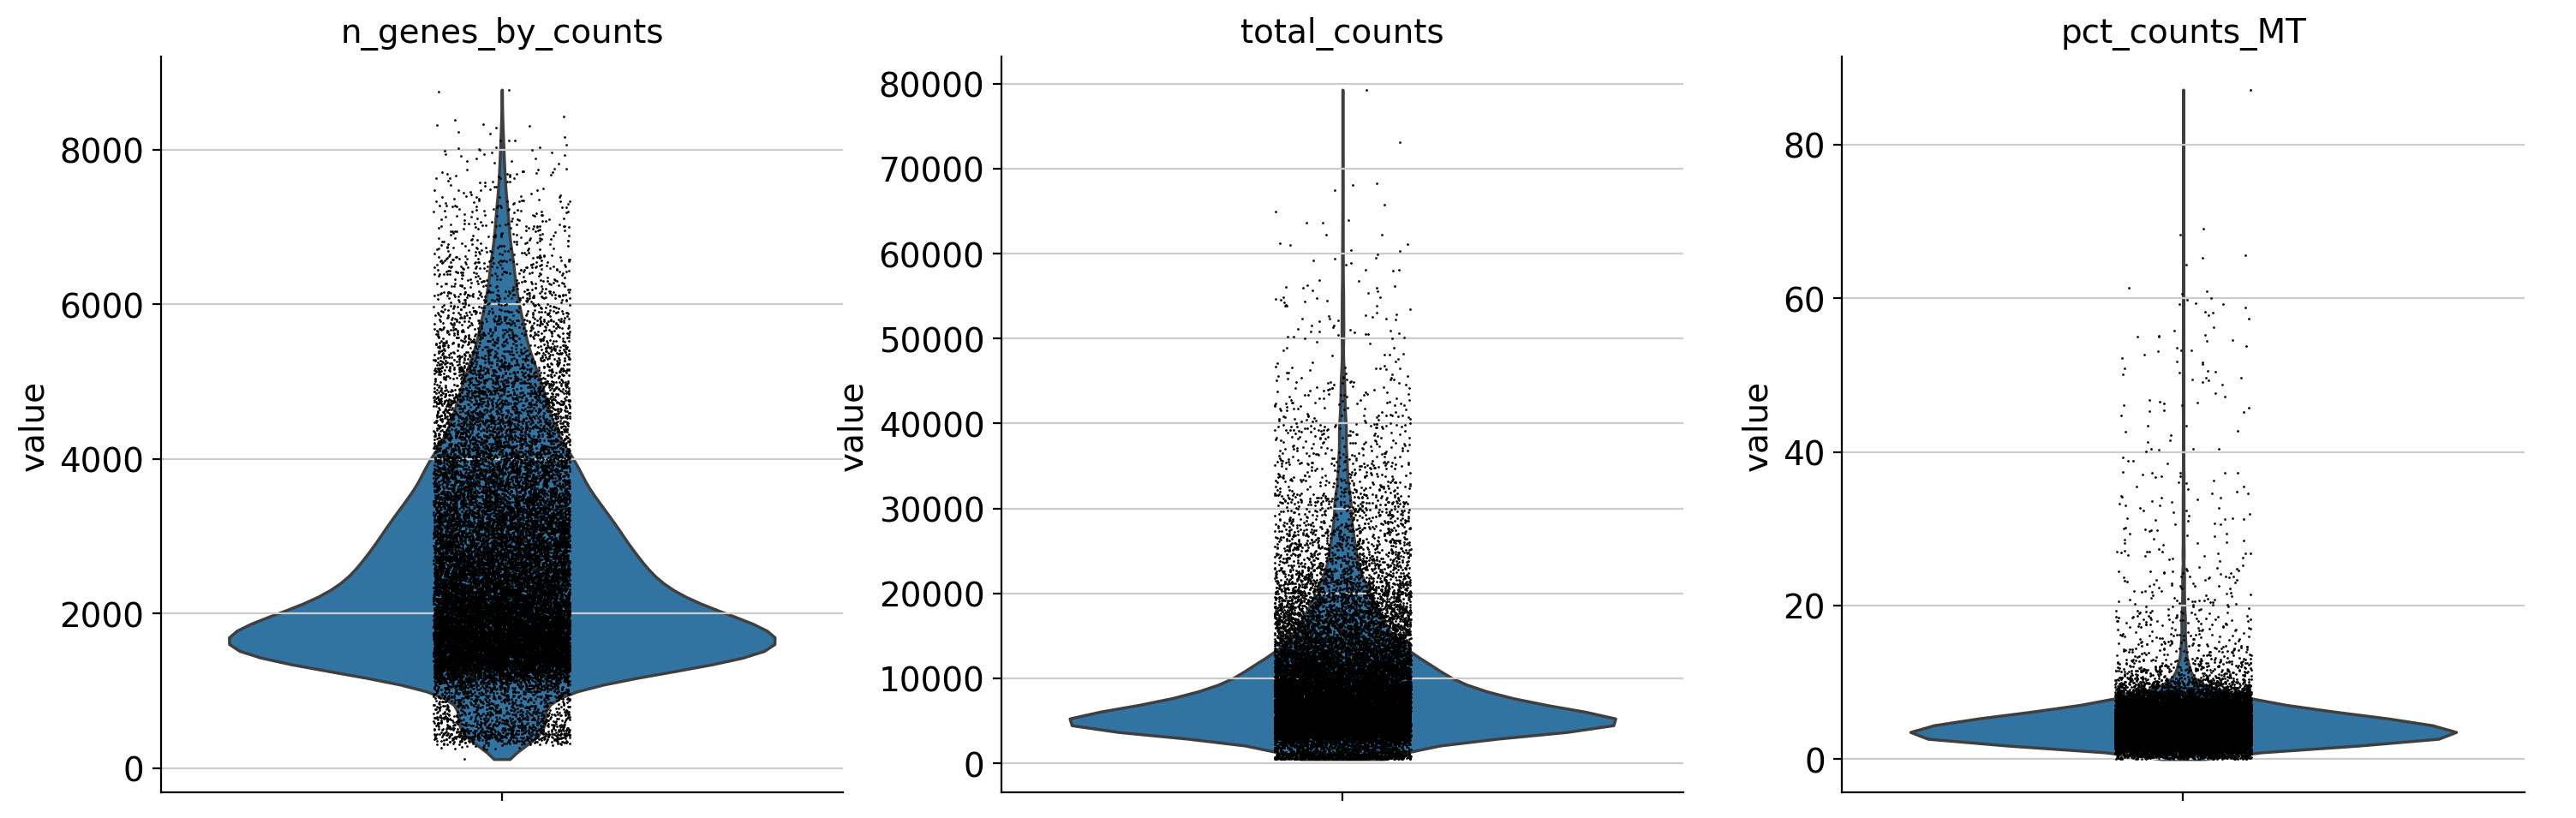


QC violin plots for: 1dpi


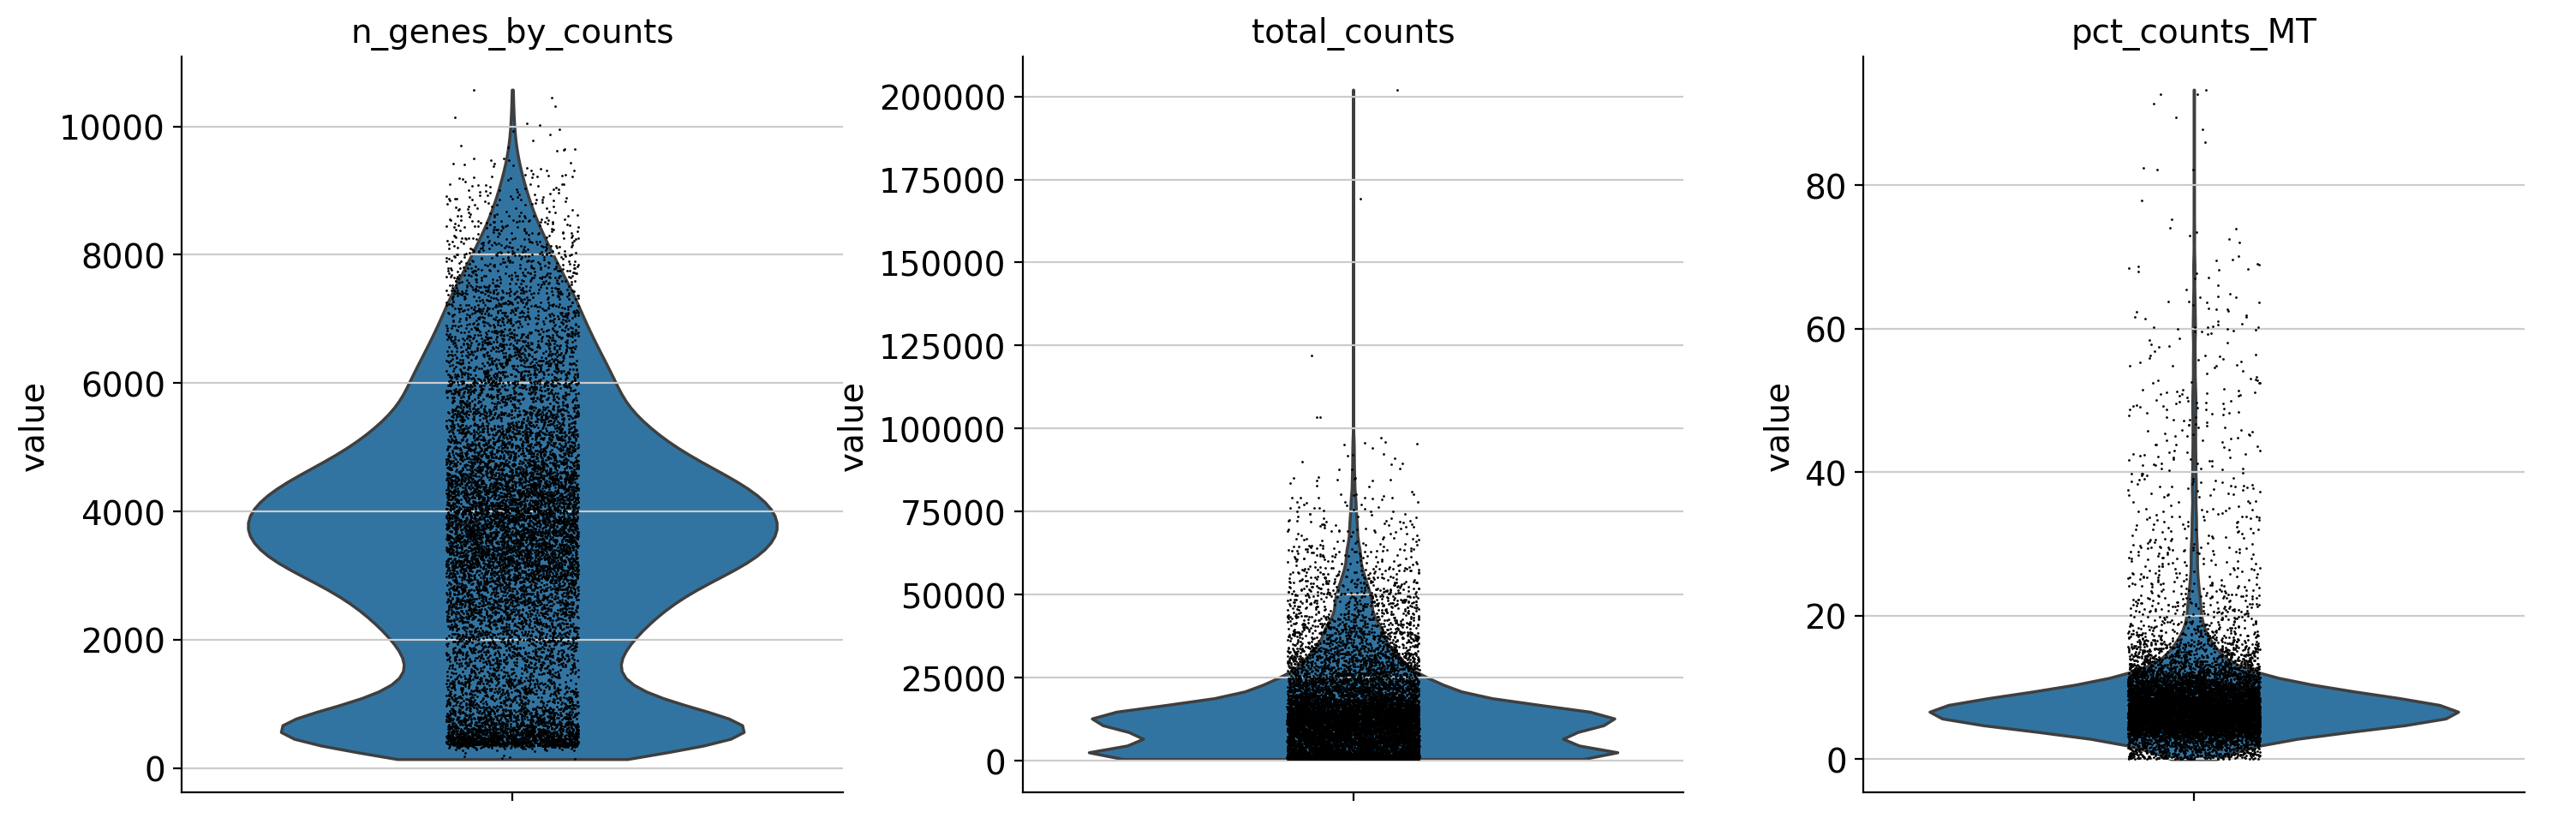


QC violin plots for: 2dpi


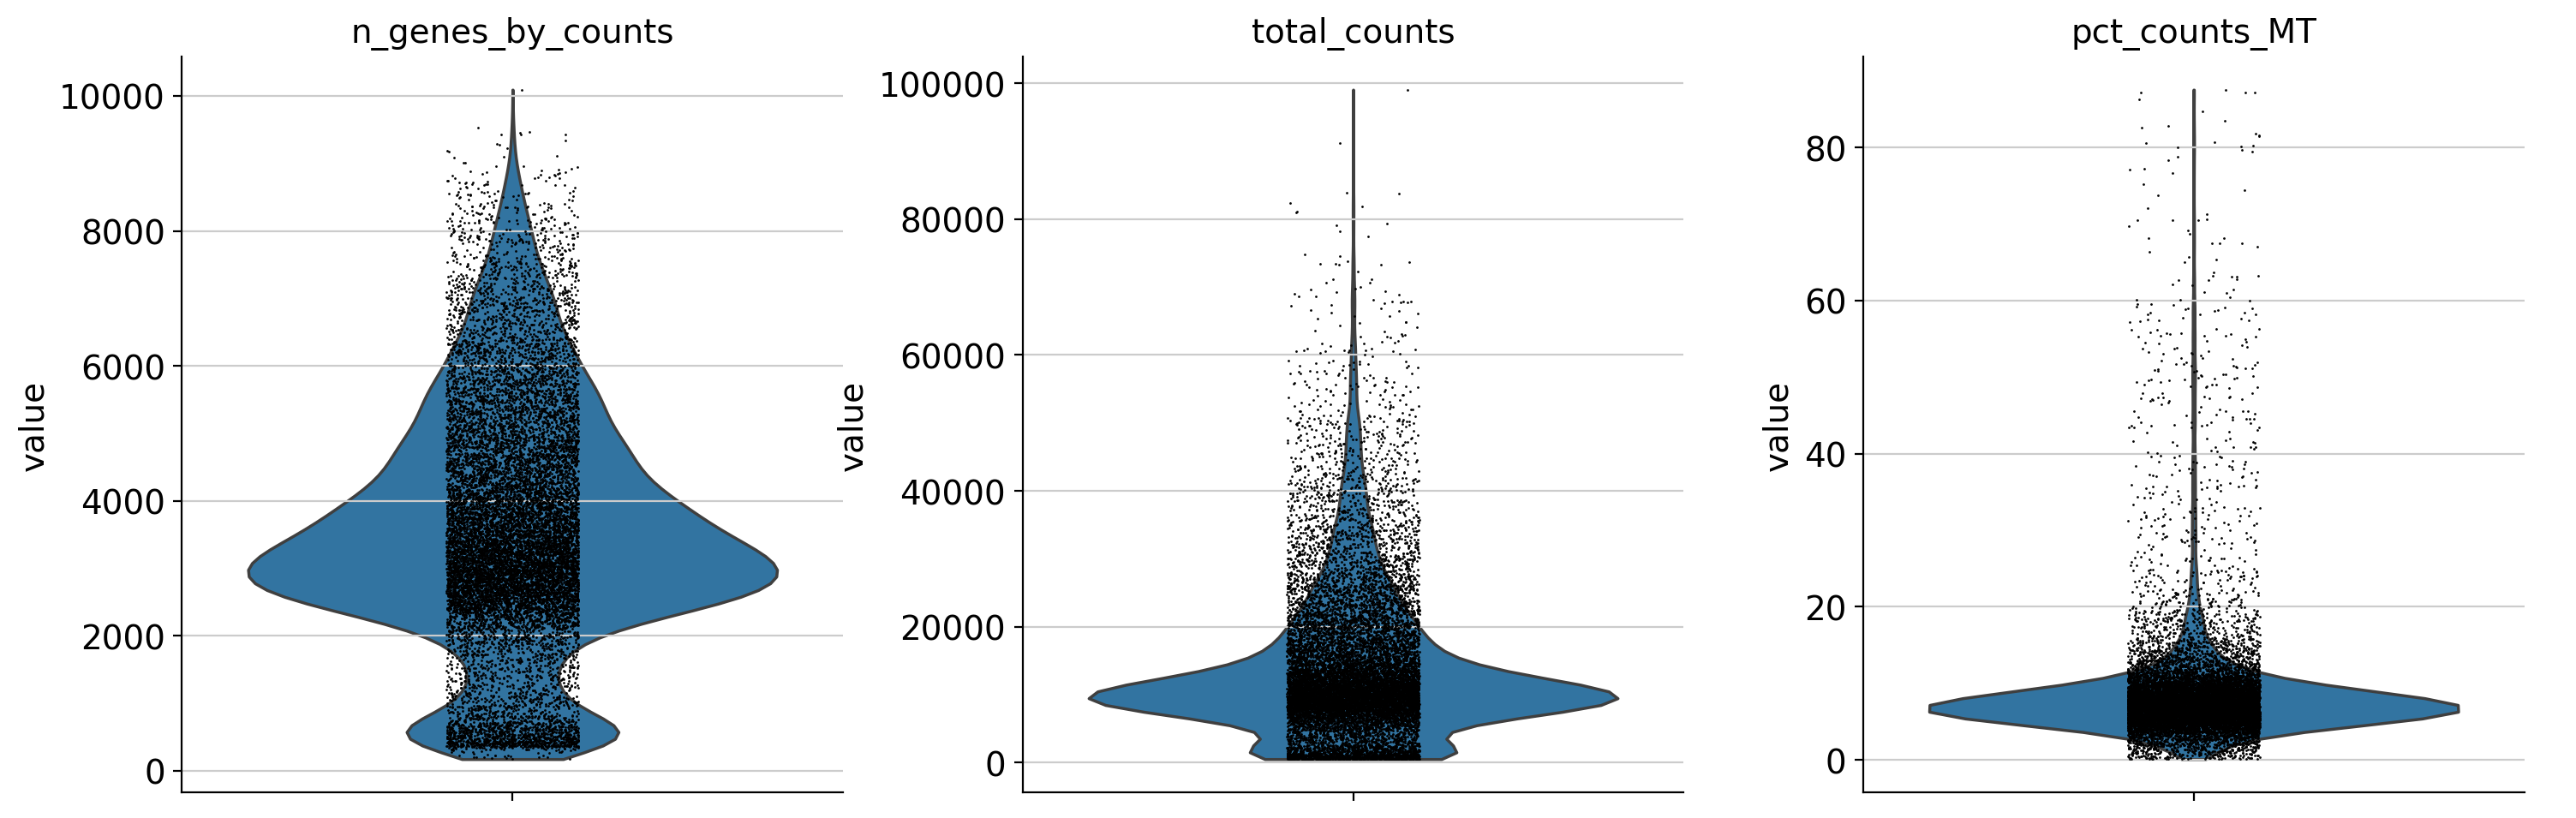


QC violin plots for: 3dpi


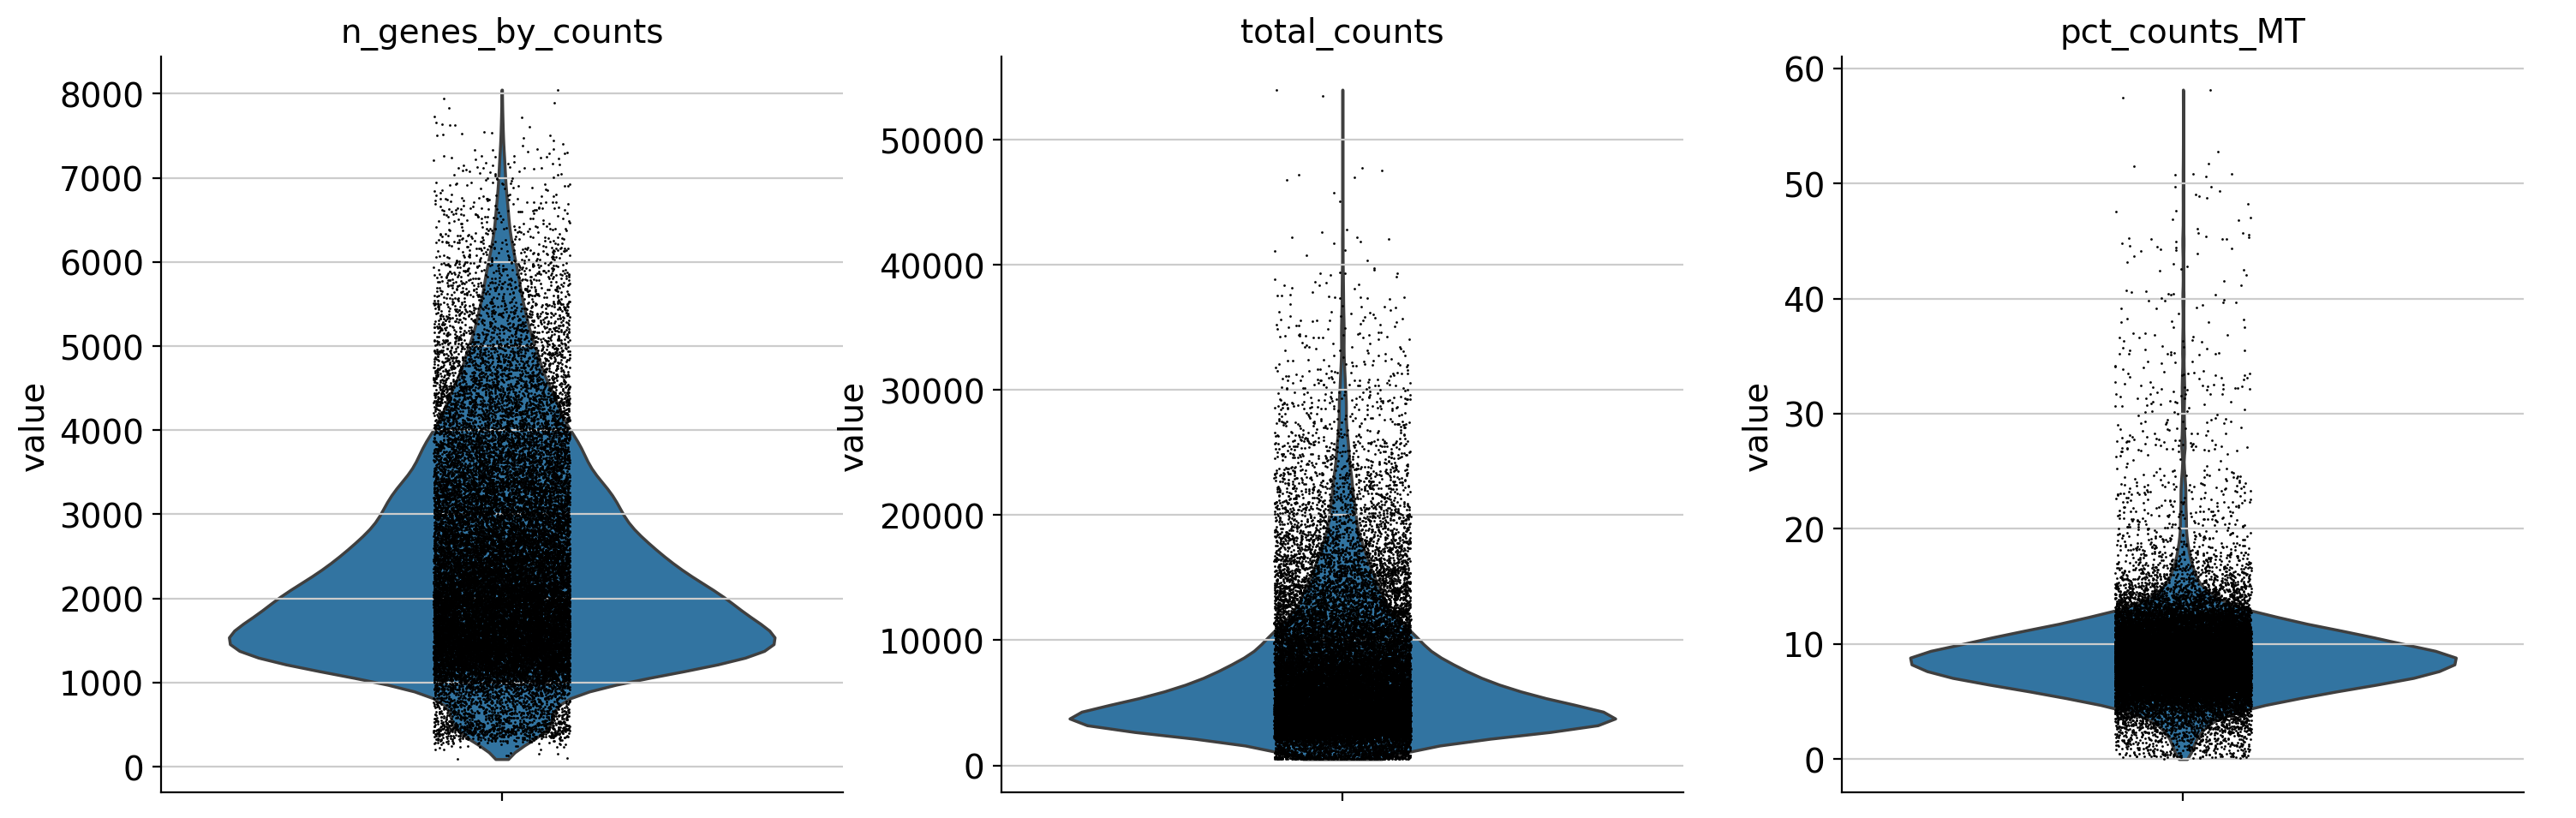

In [8]:
# Visualize QC distributions
for name, ds in zip(["mock","1dpi","2dpi","3dpi"], [mock, dpi1, dpi2, dpi3]):
    print(f"\nQC violin plots for: {name}")
    sc.pl.violin(
        ds,
        ["n_genes_by_counts", "total_counts", "pct_counts_MT"],
        multi_panel=True
    )

In [9]:
# 4) Filter out damaged / low-quality cells

def filter_cells(adata):
    """
    Applies standard scRNA-seq cell filtering:
    - remove cells with too few genes
    - remove cells with high mitochondrial percentage (dying cells)
    """
    adata = adata[adata.obs['n_genes_by_counts'] > 200, :]     # keep sufficiently complex cells
    adata = adata[adata.obs['pct_counts_MT'] < 20, :]          # drop cells with high MT stress
    return adata

mock_f = filter_cells(mock)
dpi1_f = filter_cells(dpi1)
dpi2_f = filter_cells(dpi2)
dpi3_f = filter_cells(dpi3)

In [10]:
import anndata as ad

# 5) Concatenate (merge into one single AnnData object)

# This keeps track of batch/sample origin inside adata.obs['batch']
adata = ad.concat([mock_f, dpi1_f, dpi2_f, dpi3_f],
                  label="batch",
                  merge="same")

print("\nCombined dataset:")
print(adata)


Combined dataset:
AnnData object with n_obs × n_vars = 75871 × 33539
    obs: 'condition', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'log1p_total_counts_RIBO', 'pct_counts_RIBO', 'total_counts_HB', 'log1p_total_counts_HB', 'pct_counts_HB', 'batch'
    var: 'gene_ids', 'feature_types', 'MT', 'RIBO', 'HB'


In [11]:
# 6) Normalization + log transform + HVG selection

# Normalize counts per cell (CPM-like)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log transform for stabilizing variance
# Re-adding this as it's recommended for 'seurat' flavor HVG selection
sc.pp.log1p(adata)

# Identify top highly-variable genes
# Changed flavor to 'seurat' as it is more appropriate for pre-normalized and log-transformed data
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat',
    n_top_genes=3000
)

normalizing counts per cell
    finished (0:00:05)
extracting highly variable genes
    finished (0:00:10)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [12]:
# Use only HVGs for downstream steps
adata = adata[:, adata.var['highly_variable']]

# Regress out technical effects, then scale each gene to unit variance
sc.pp.scale(adata, max_value=10)

In [14]:
# 7) Dimensionality reduction (PCA) + neighborhood graph

sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)

computing PCA
    with n_comps=50
    finished (0:01:13)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:46)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:31)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:02:00)


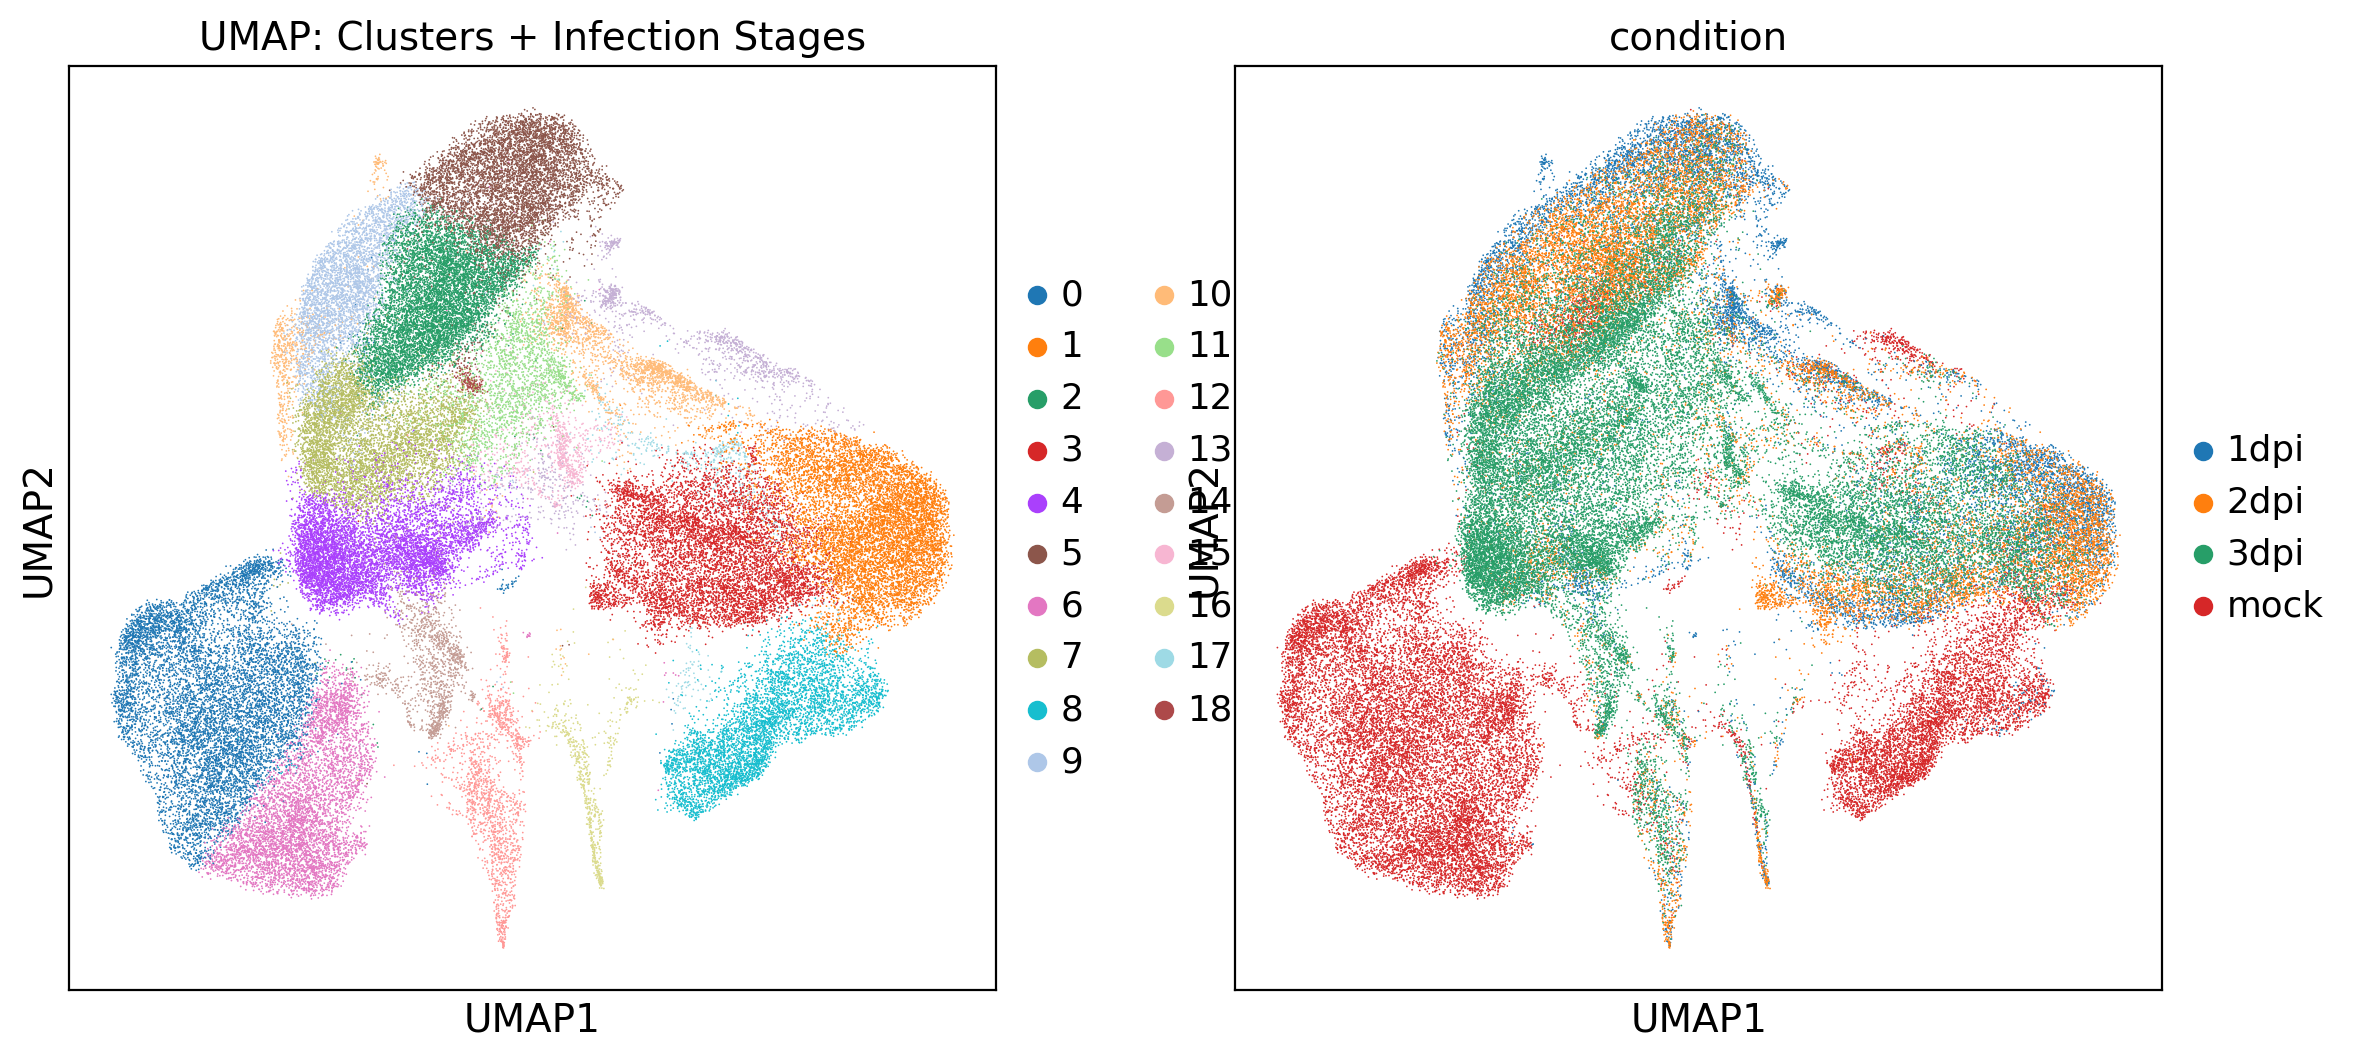

In [15]:
# 8) UMAP + Leiden clustering

sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)  # adjust resolution if needed

sc.pl.umap(adata, color=['leiden','condition'],
           title="UMAP: Clusters + Infection Stages")

In [19]:
# 9) Marker genes for airway cell-type identification

marker_genes = {
    "Basal":     ["KRT5", "TP63"],
    "Ciliated":  ["FOXJ1", "TUBB4B"],
    "Club":      ["SCGB1A1"],
    "Goblet":    ["MUC5AC", "MUC5B"],
    "Ionocyte":  ["FOXI1", "CFTR"],
    "Immune":    ["PTPRC", "LYZ"]
}

In [22]:
# 10) Assign cell types manually based on dotplot

cluster2type = {
    '0': 'Ciliated',
    '1': 'Basal',
    '2': 'Club',
    '3': 'Goblet',
    '4': 'Ionocyte',
    '5': 'Immune'
}

categories: 0, 1, 2, etc.
var_group_labels: Basal, Ciliated, Club, etc.


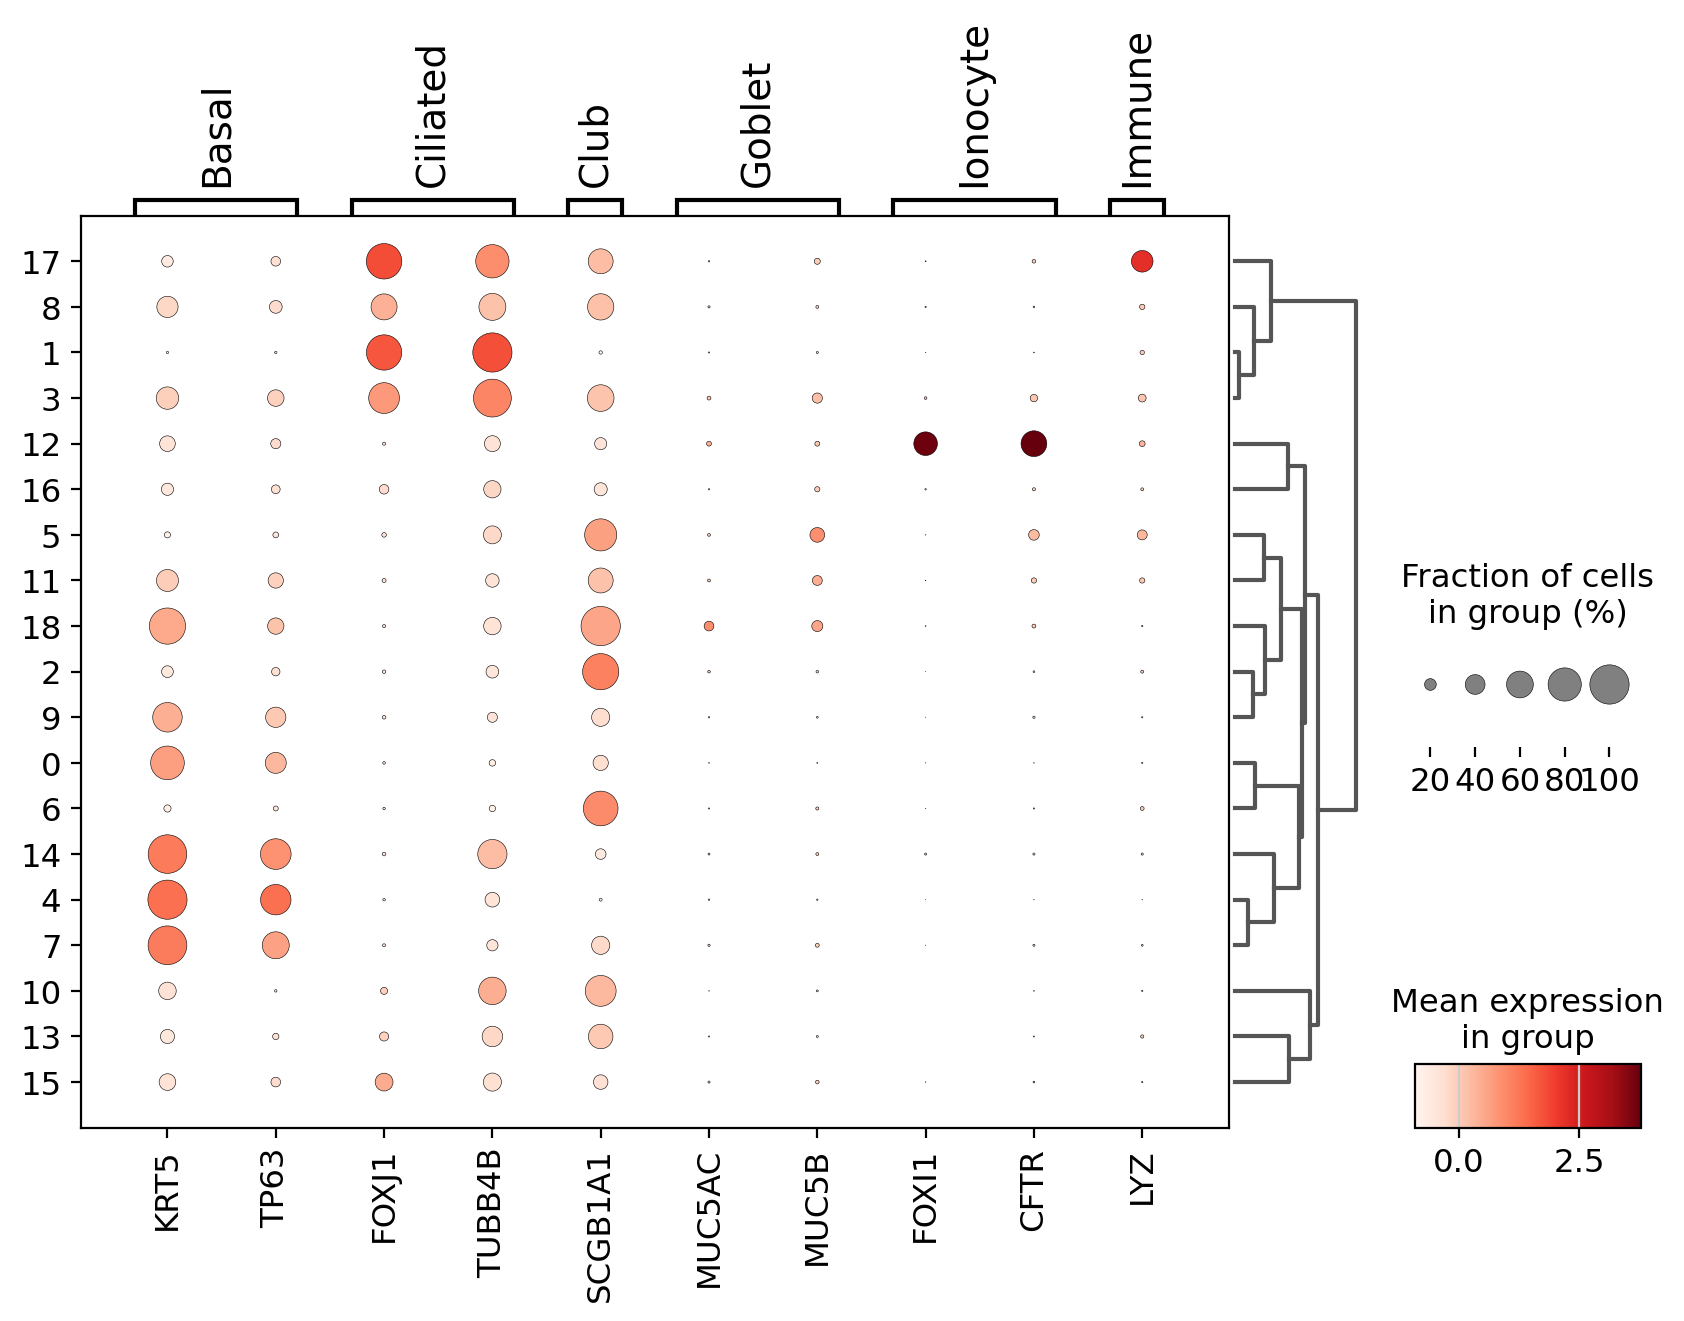

In [28]:
# Filter marker genes to only include those present in adata.var_names
filtered_marker_genes = {}
for cell_type, genes in marker_genes.items():
    present_genes = [gene for gene in genes if gene in adata.var_names]
    if present_genes:
        filtered_marker_genes[cell_type] = present_genes

# Check if any marker genes remain for plotting
if not filtered_marker_genes:
    print("Warning: No marker genes found in the dataset after filtering for highly variable genes. Cannot create dot plot.")
else:
    # Generate dotplot
    dp = sc.pl.dotplot(
        adata,
        filtered_marker_genes,
        groupby='leiden',
        dendrogram=True,
        title=None, # Removed title
        figsize=(10, 6),
        show=False # Prevent immediate showing so we can adjust layout
    )
    # The 'dp' object returned by sc.pl.dotplot appears to be a dictionary of axes, not a DotPlot object.
    # We access the figure from one of the axes in the dictionary to apply tight_layout.
    if isinstance(dp, dict) and 'mainplot_ax' in dp:
        dp['mainplot_ax'].figure.tight_layout()
    else:
        # Fallback if dp is not a dictionary or 'mainplot_ax' is not present
        plt.gcf().tight_layout()
    plt.show()

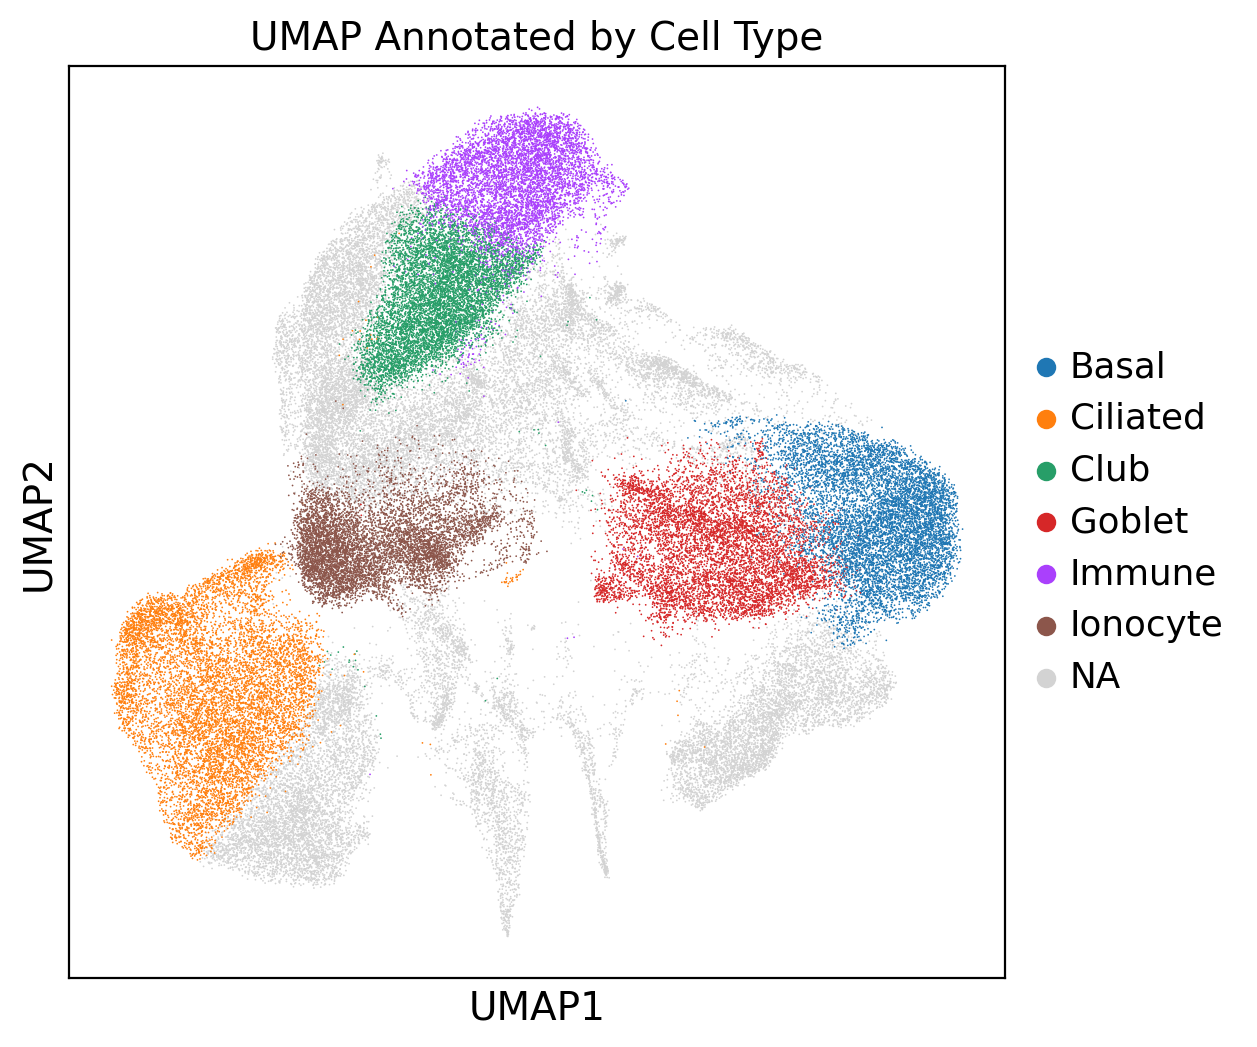


=== Initial dataset preprocessing complete ===


In [23]:

adata.obs['cell_type'] = adata.obs['leiden'].map(cluster2type)

sc.pl.umap(adata, color='cell_type',
           title="UMAP Annotated by Cell Type")

print("\n=== Initial dataset preprocessing complete ===")

In [29]:
# quick sanity check
assert 'dpt_pseudotime' not in adata.obs, "Pseudotime already present; remove or overwrite if desired."
assert 'leiden' in adata.obs or 'cell_type' in adata.obs, "Need cluster labels in adata.obs['leiden'] or adata.obs['cell_type']"


In [30]:
if 'cell_type' in adata.obs and 'Basal' in adata.obs['cell_type'].unique():
    root_cells = adata.obs_names[adata.obs['cell_type'] == 'Basal']
    print("Root = Basal (cell_type).")

Root = Basal (cell_type).


In [31]:
# compute diffusion map (stores result in adata.obsm['X_diffmap'])
sc.tl.diffmap(adata)

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99742174 0.99659085 0.99364334 0.99319303 0.99065125
     0.9882073  0.9868788  0.9834095  0.9816728  0.98033327 0.9799134
     0.9793366  0.97800744 0.9776515 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:11)


In [33]:
# Select a root cell for DPT. Scanpy's dpt function expects the root cell to be set in adata.uns['iroot'].
# We'll pick the first cell from the 'Basal' cell type identified previously.
if len(root_cells) > 0:
    # Get the index of the first root cell as an integer
    adata.uns['iroot'] = np.flatnonzero(adata.obs_names == root_cells[0])[0]
    print(f"Set root cell index to: {adata.uns['iroot']} (Cell: {root_cells[0]})")
else:
    raise ValueError("No root cells found to compute DPT. Please ensure 'Basal' cells are present.")

# compute DPT without the 'root_cells' argument
sc.tl.dpt(adata, n_dcs=10)

# result stored in adata.obs['dpt_pseudotime']
print("Pseudotime range:", adata.obs['dpt_pseudotime'].min(), "→", adata.obs['dpt_pseudotime'].max())

Set root cell index to: 17 (Cell: AAACCCAGTTGCTAGT-1)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
Pseudotime range: 0.0 → 1.0


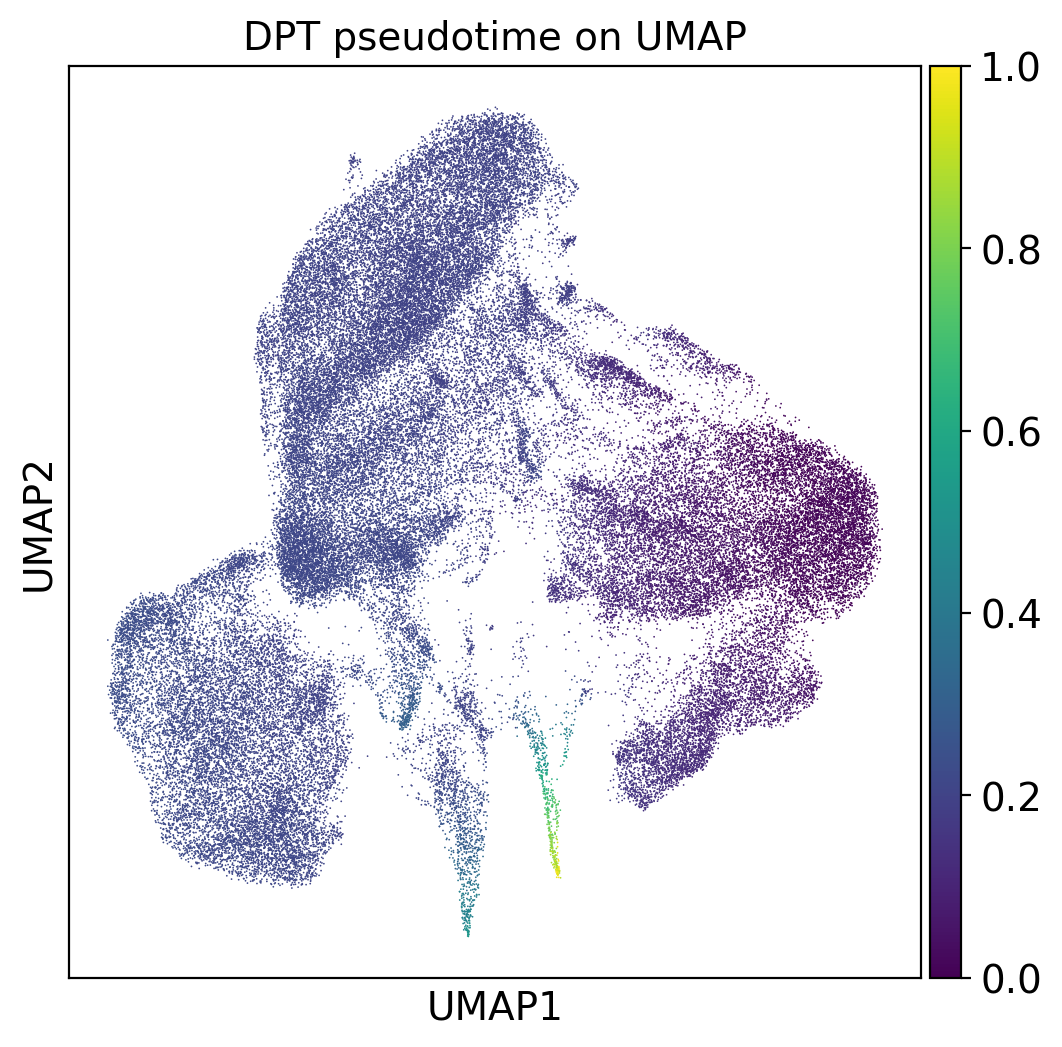

In [34]:
sc.pl.umap(adata, color='dpt_pseudotime', cmap='viridis', title="DPT pseudotime on UMAP")

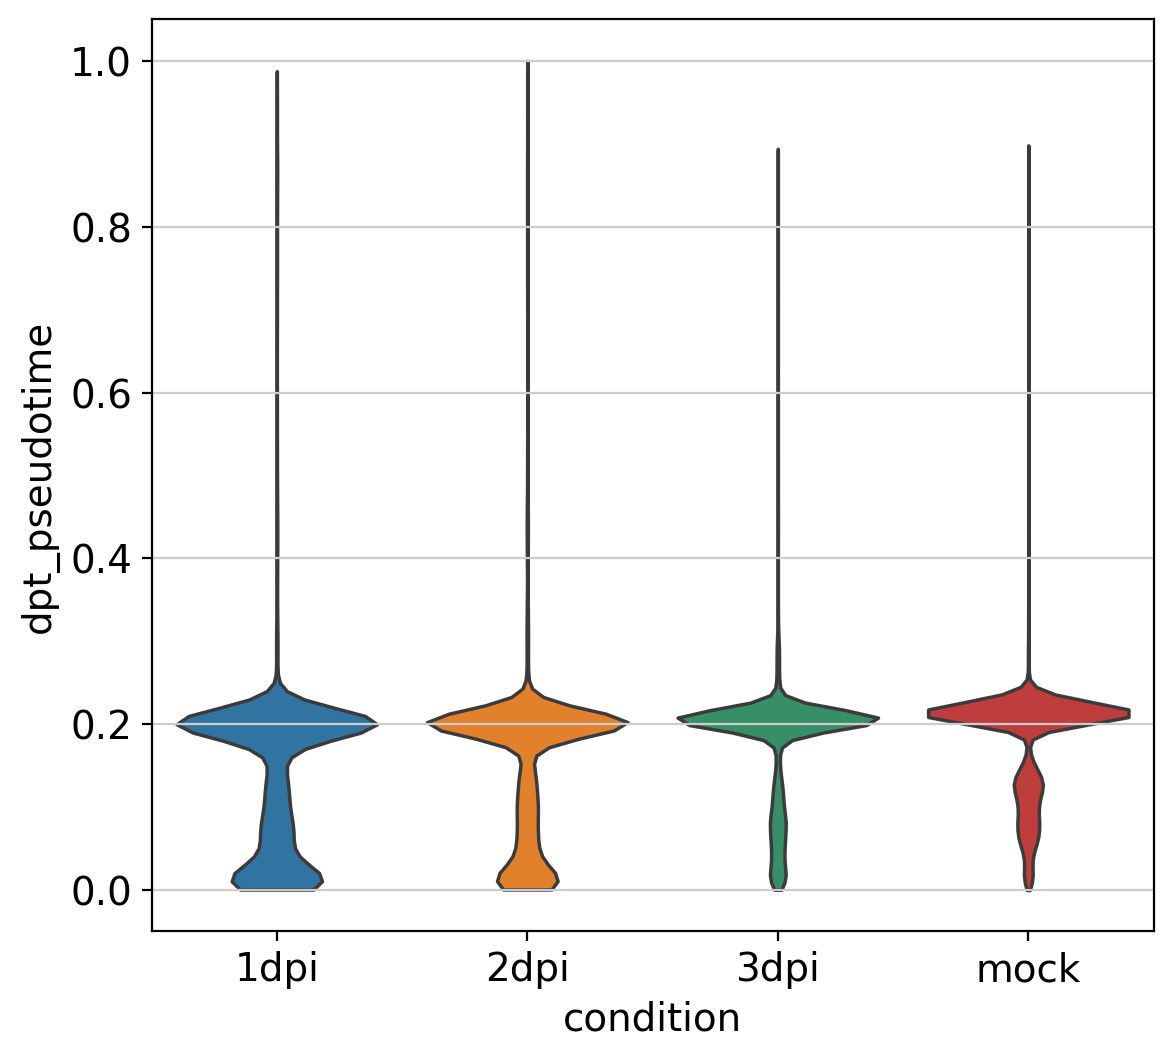

In [36]:
sc.pl.violin(adata, keys='dpt_pseudotime', groupby='condition', stripplot=False, jitter=0.4)

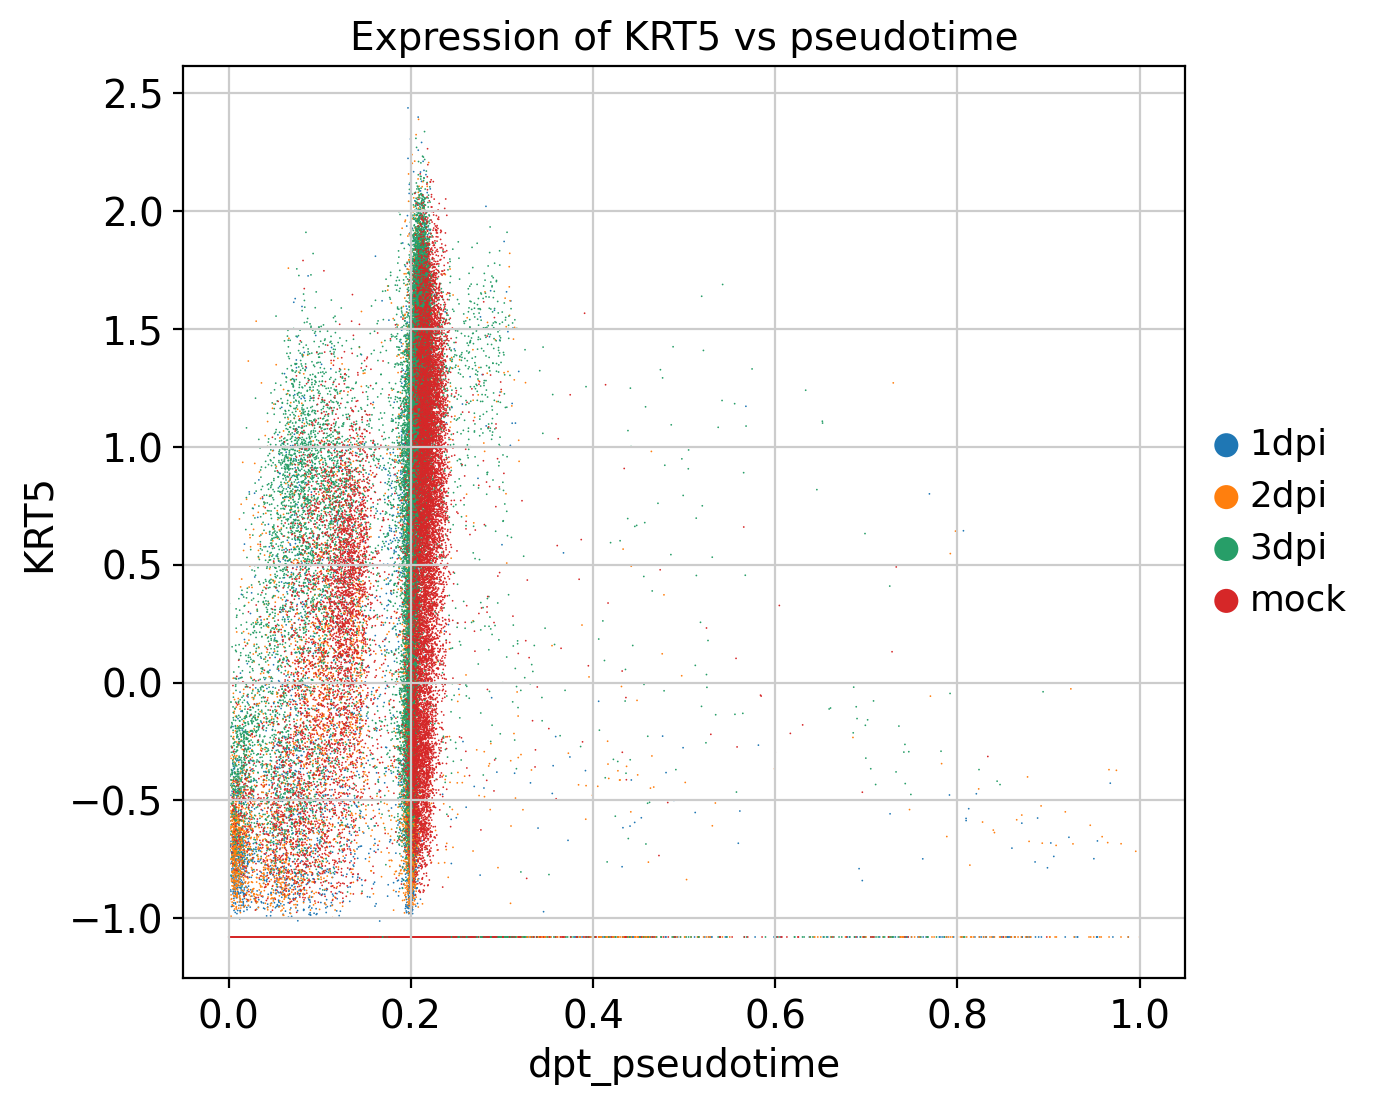

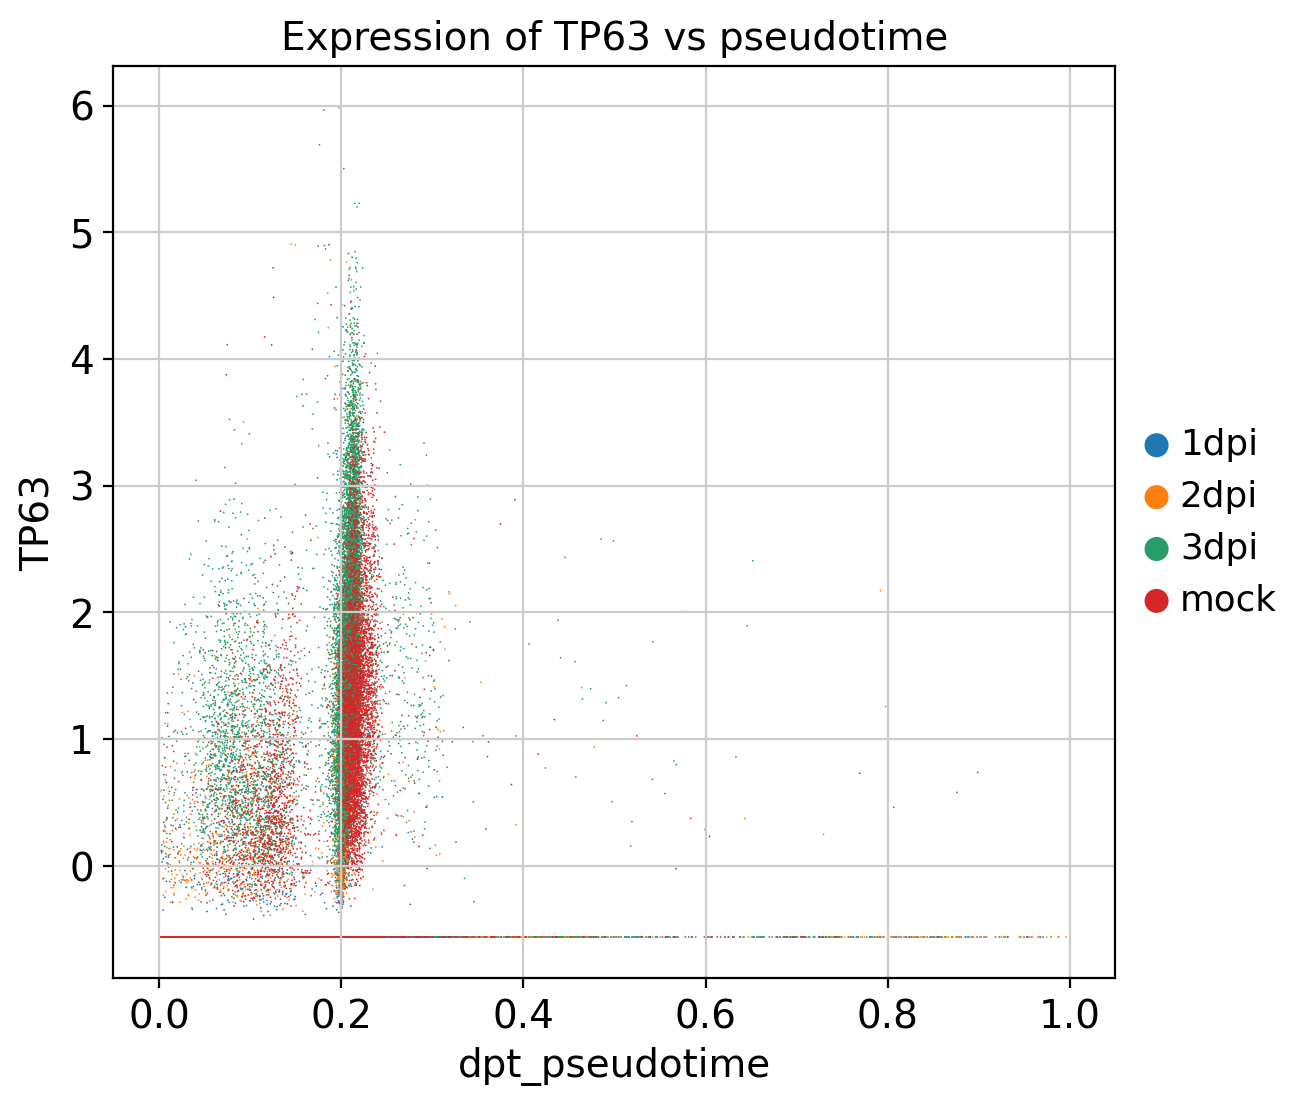

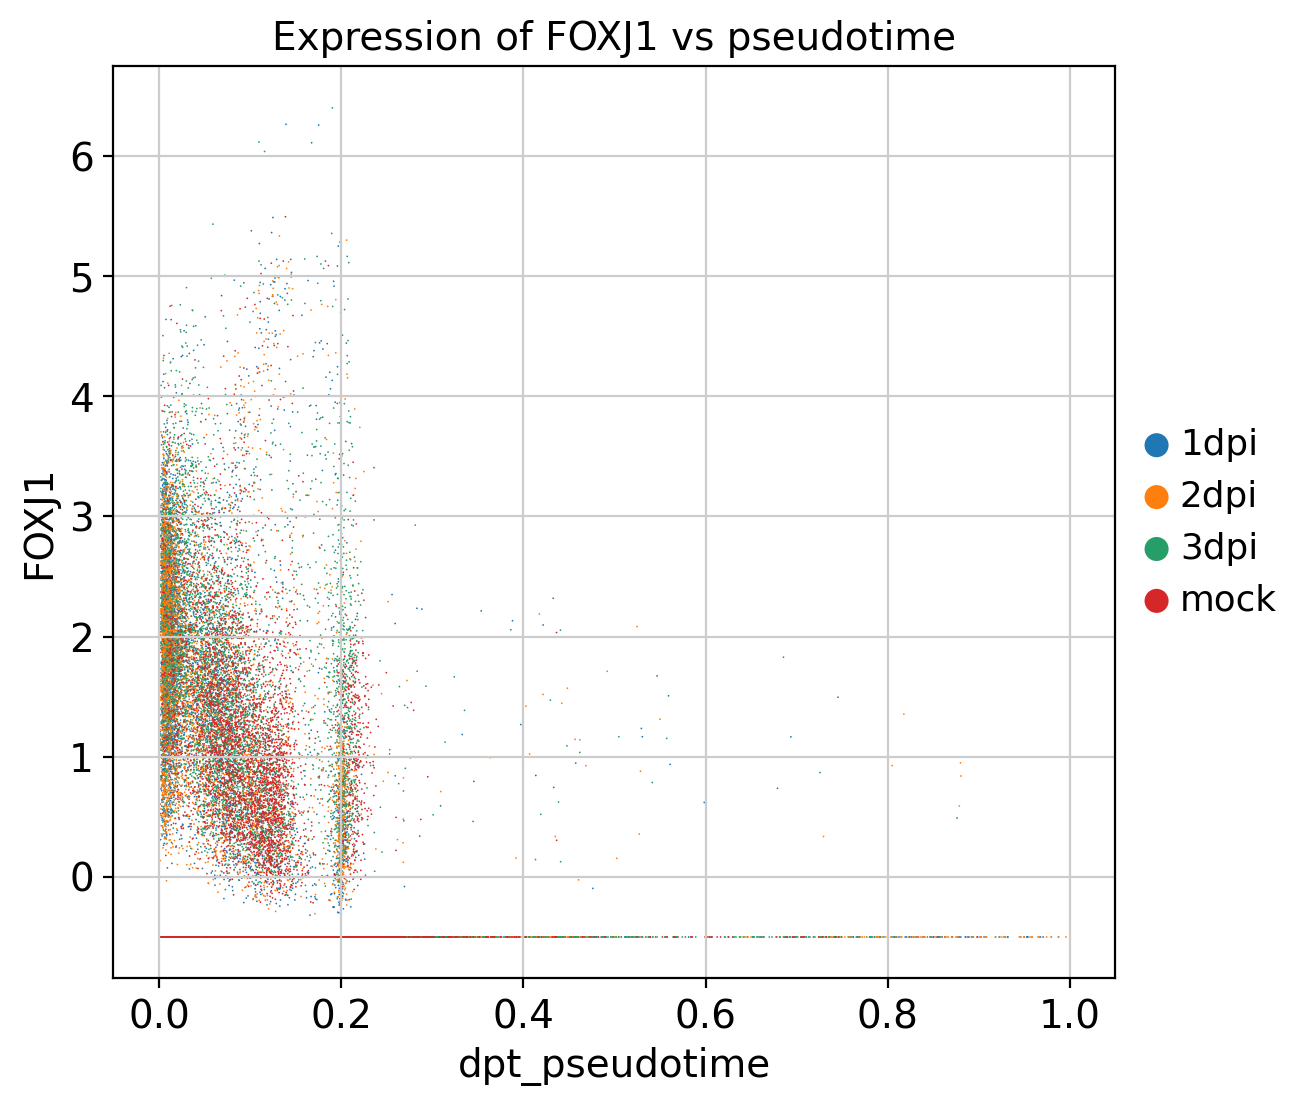

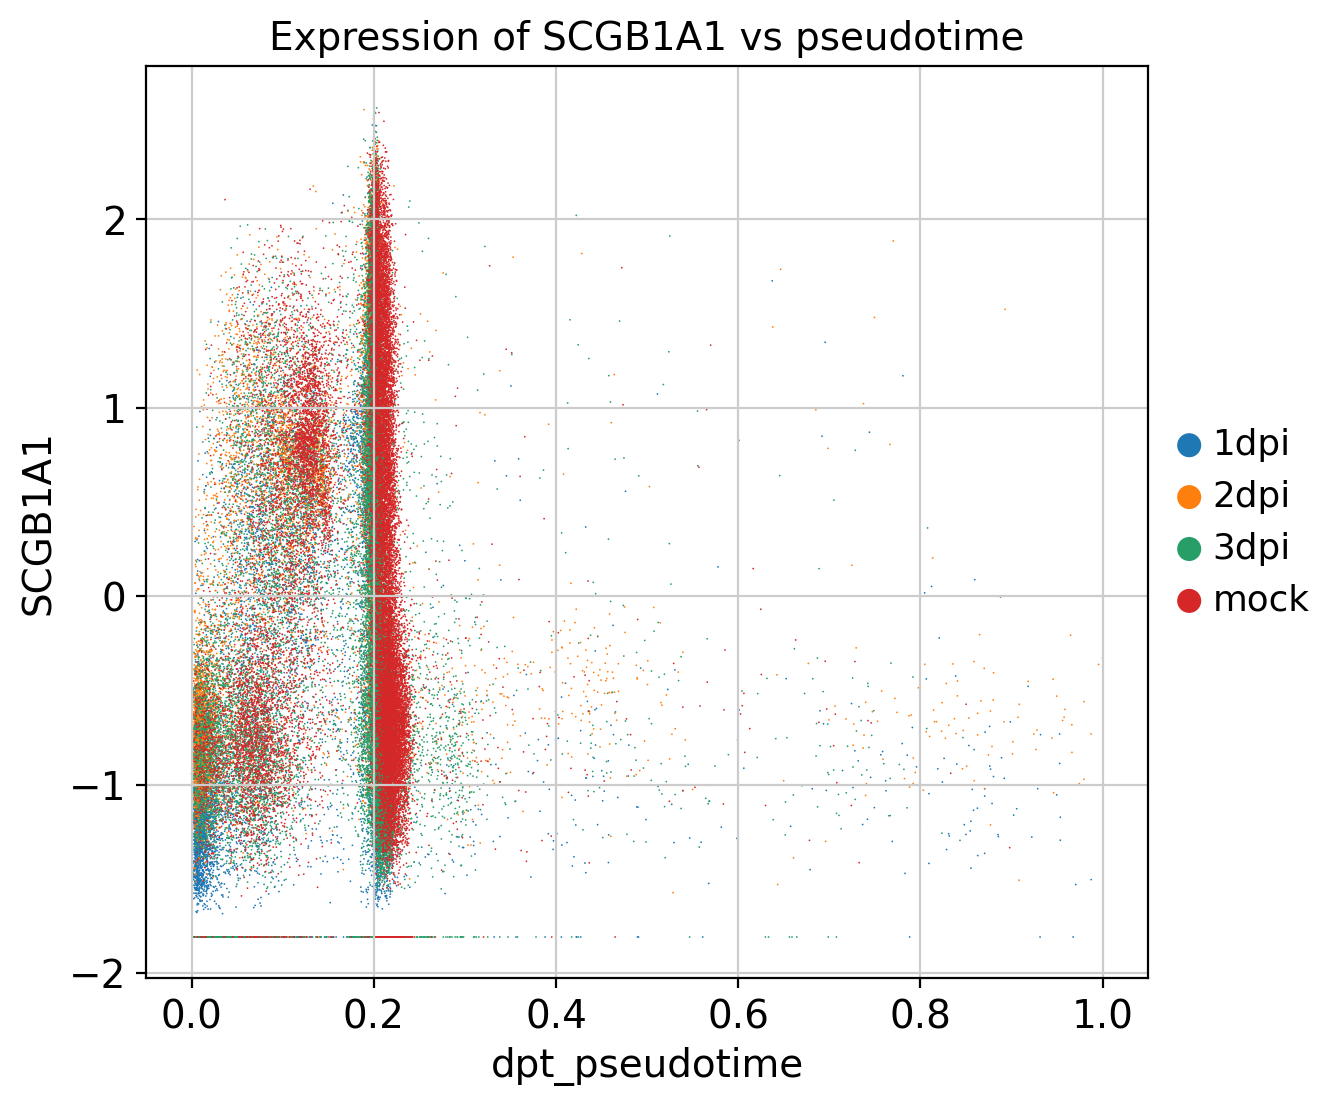

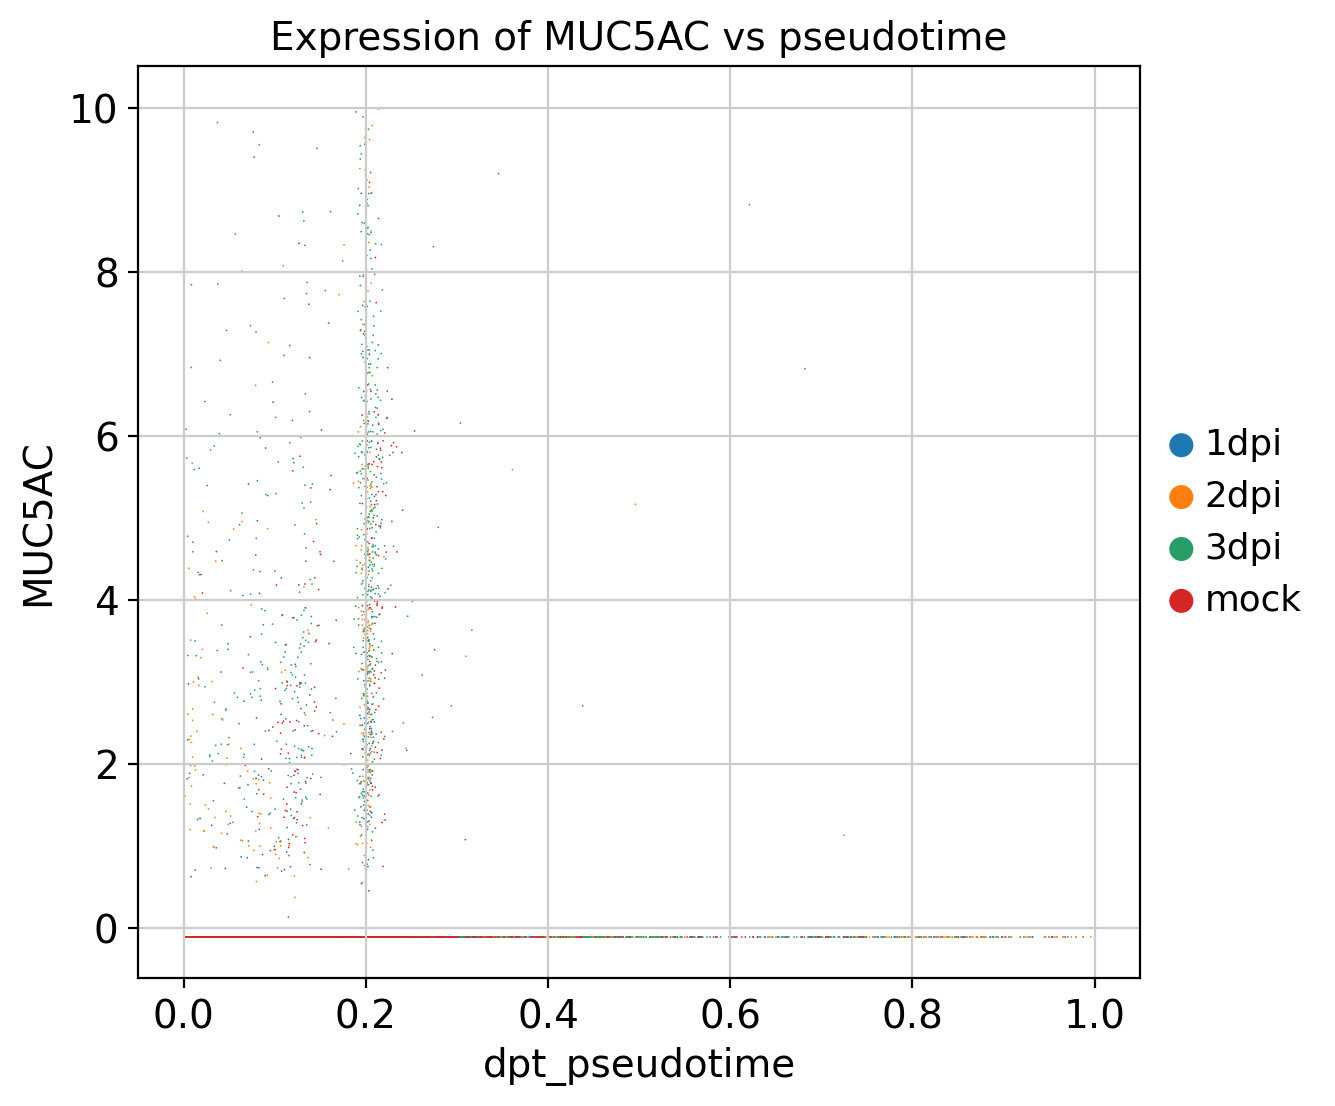

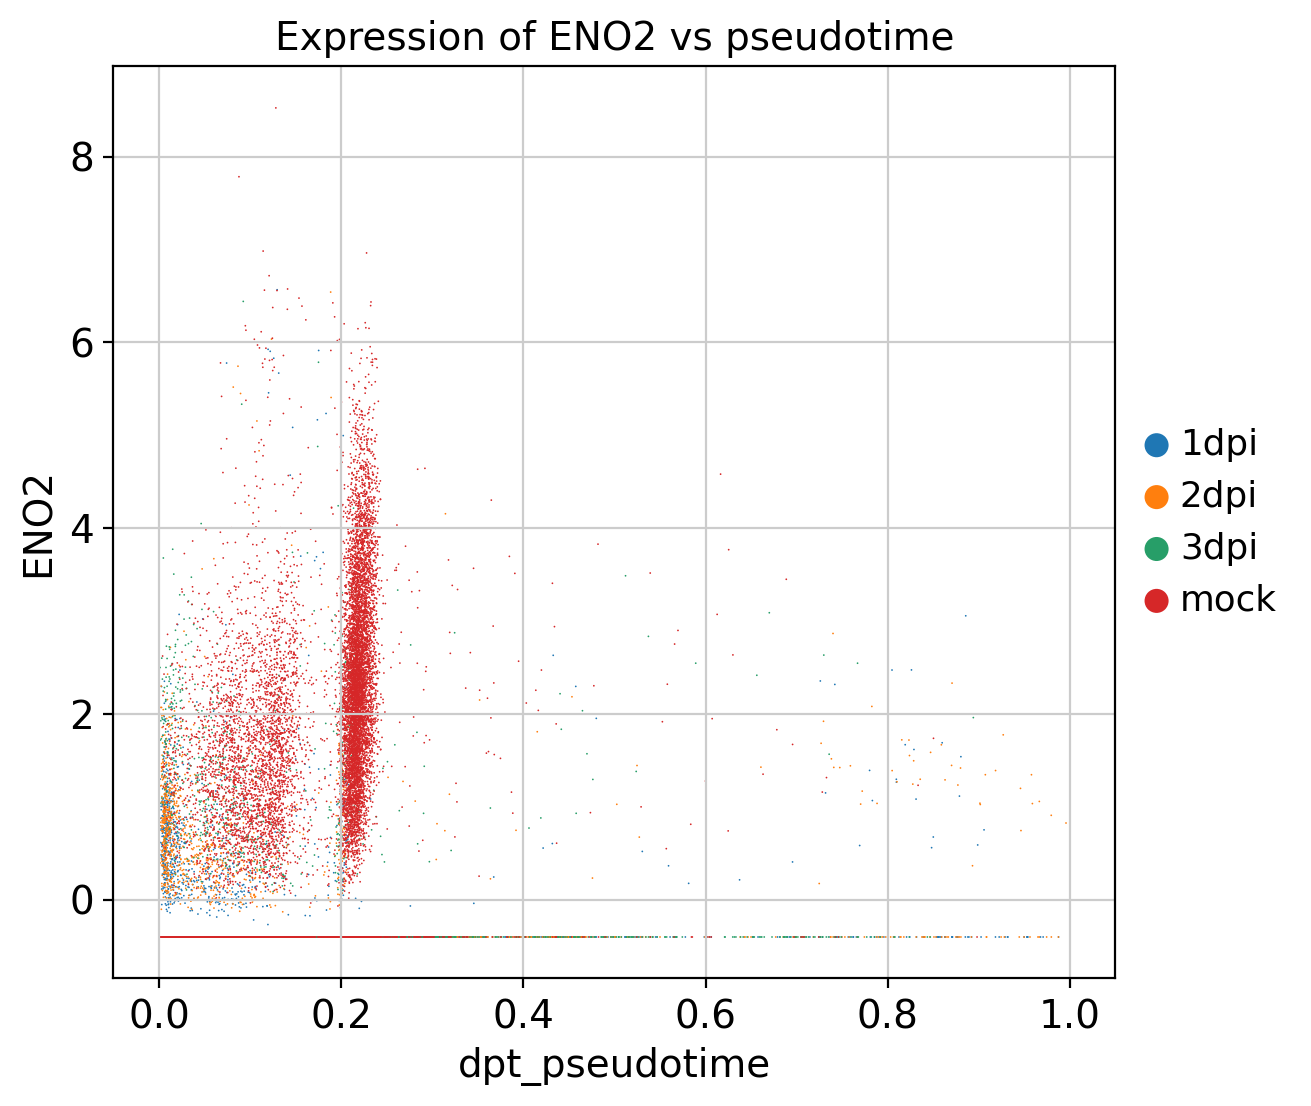

In [38]:
genes = [g for g in ["KRT5","TP63","KRT8","FOXJ1","SCGB1A1","MUC5AC","ACE2","ENO2"] if g in adata.var_names]

for gene in genes:
    sc.pl.scatter(adata, x='dpt_pseudotime', y=gene, color='condition', title=f"Expression of {gene} vs pseudotime")